In [9]:
import json
import matplotlib.pyplot as plt

def make_plot(experiment):
    with open(f"{experiment}.json", "r") as f:
        metrics = json.load(f)

    rounds = [int(k) for k in metrics.keys()]
    rounds.sort()
    
    metric_names = ["loss", "cen_accuracy", "kappa", "f1", "roc_auc"]

    fig, axes = plt.subplots(3, 2, figsize=(14, 12))
    fig.suptitle(experiment, fontsize=20)

    axes = axes.flatten()
    
    for i, metric_name in enumerate(metric_names):
        values = [metrics[str(r)][metric_name] for r in rounds]
        axes[i].plot(rounds, values)
        if metric_name == "loss":
            axes[i].set_title(metric_name + " " + str(round(min(values), 2)), fontsize=14)
        else:
            axes[i].set_title(metric_name + " " + str(round(max(values), 2)), fontsize=14)
        axes[i].set_xlabel("Round")
        axes[i].set_ylabel(metric_name)
    
    axes[-1].axis("off")
    
    plt.tight_layout()
    plt.show()


In [7]:
import json
import matplotlib.pyplot as plt

def plot(experiments):
    # experiments is a list like:
    # ["Base_model_IID", "Base_model_IID_1", "Base_model_IID_2"]

    metric_names = ["loss", "cen_accuracy", "kappa", "f1", "roc_auc"]

    fig, axes = plt.subplots(3, 2, figsize=(20, 15))
    # fig.suptitle(" | ".join(experiments), fontsize=20)
    axes = axes.flatten()

    # Load all experiments
    all_data = {}

    for exp in experiments:
        with open(f"{exp}.json", "r") as f:
            metrics = json.load(f)
        rounds = sorted([int(k) for k in metrics.keys()])
        all_data[exp] = {
            "rounds": rounds,
            "metrics": metrics
        }

    # Plotting
    for i, metric_name in enumerate(metric_names):
        ax = axes[i]
        
        for exp in experiments:
            rounds = all_data[exp]["rounds"]
            metrics = all_data[exp]["metrics"]

            values = [metrics[str(r)][metric_name] for r in rounds]
            ax.plot(rounds, values, label=exp)

        # Titles: min for loss, max for others
        all_values = []
        for exp in experiments:
            all_values.extend([all_data[exp]["metrics"][str(r)][metric_name] for r in all_data[exp]["rounds"]])

        if metric_name == "loss":
            title_stats = str(round(min(all_values), 2))
        else:
            title_stats = str(round(max(all_values), 2))

        ax.set_title(f"{metric_name} {title_stats}", fontsize=14)
        ax.set_xlabel("Round")
        ax.set_ylabel(metric_name)
        ax.legend()

    axes[-1].axis("off")
    plt.tight_layout()
    plt.show()

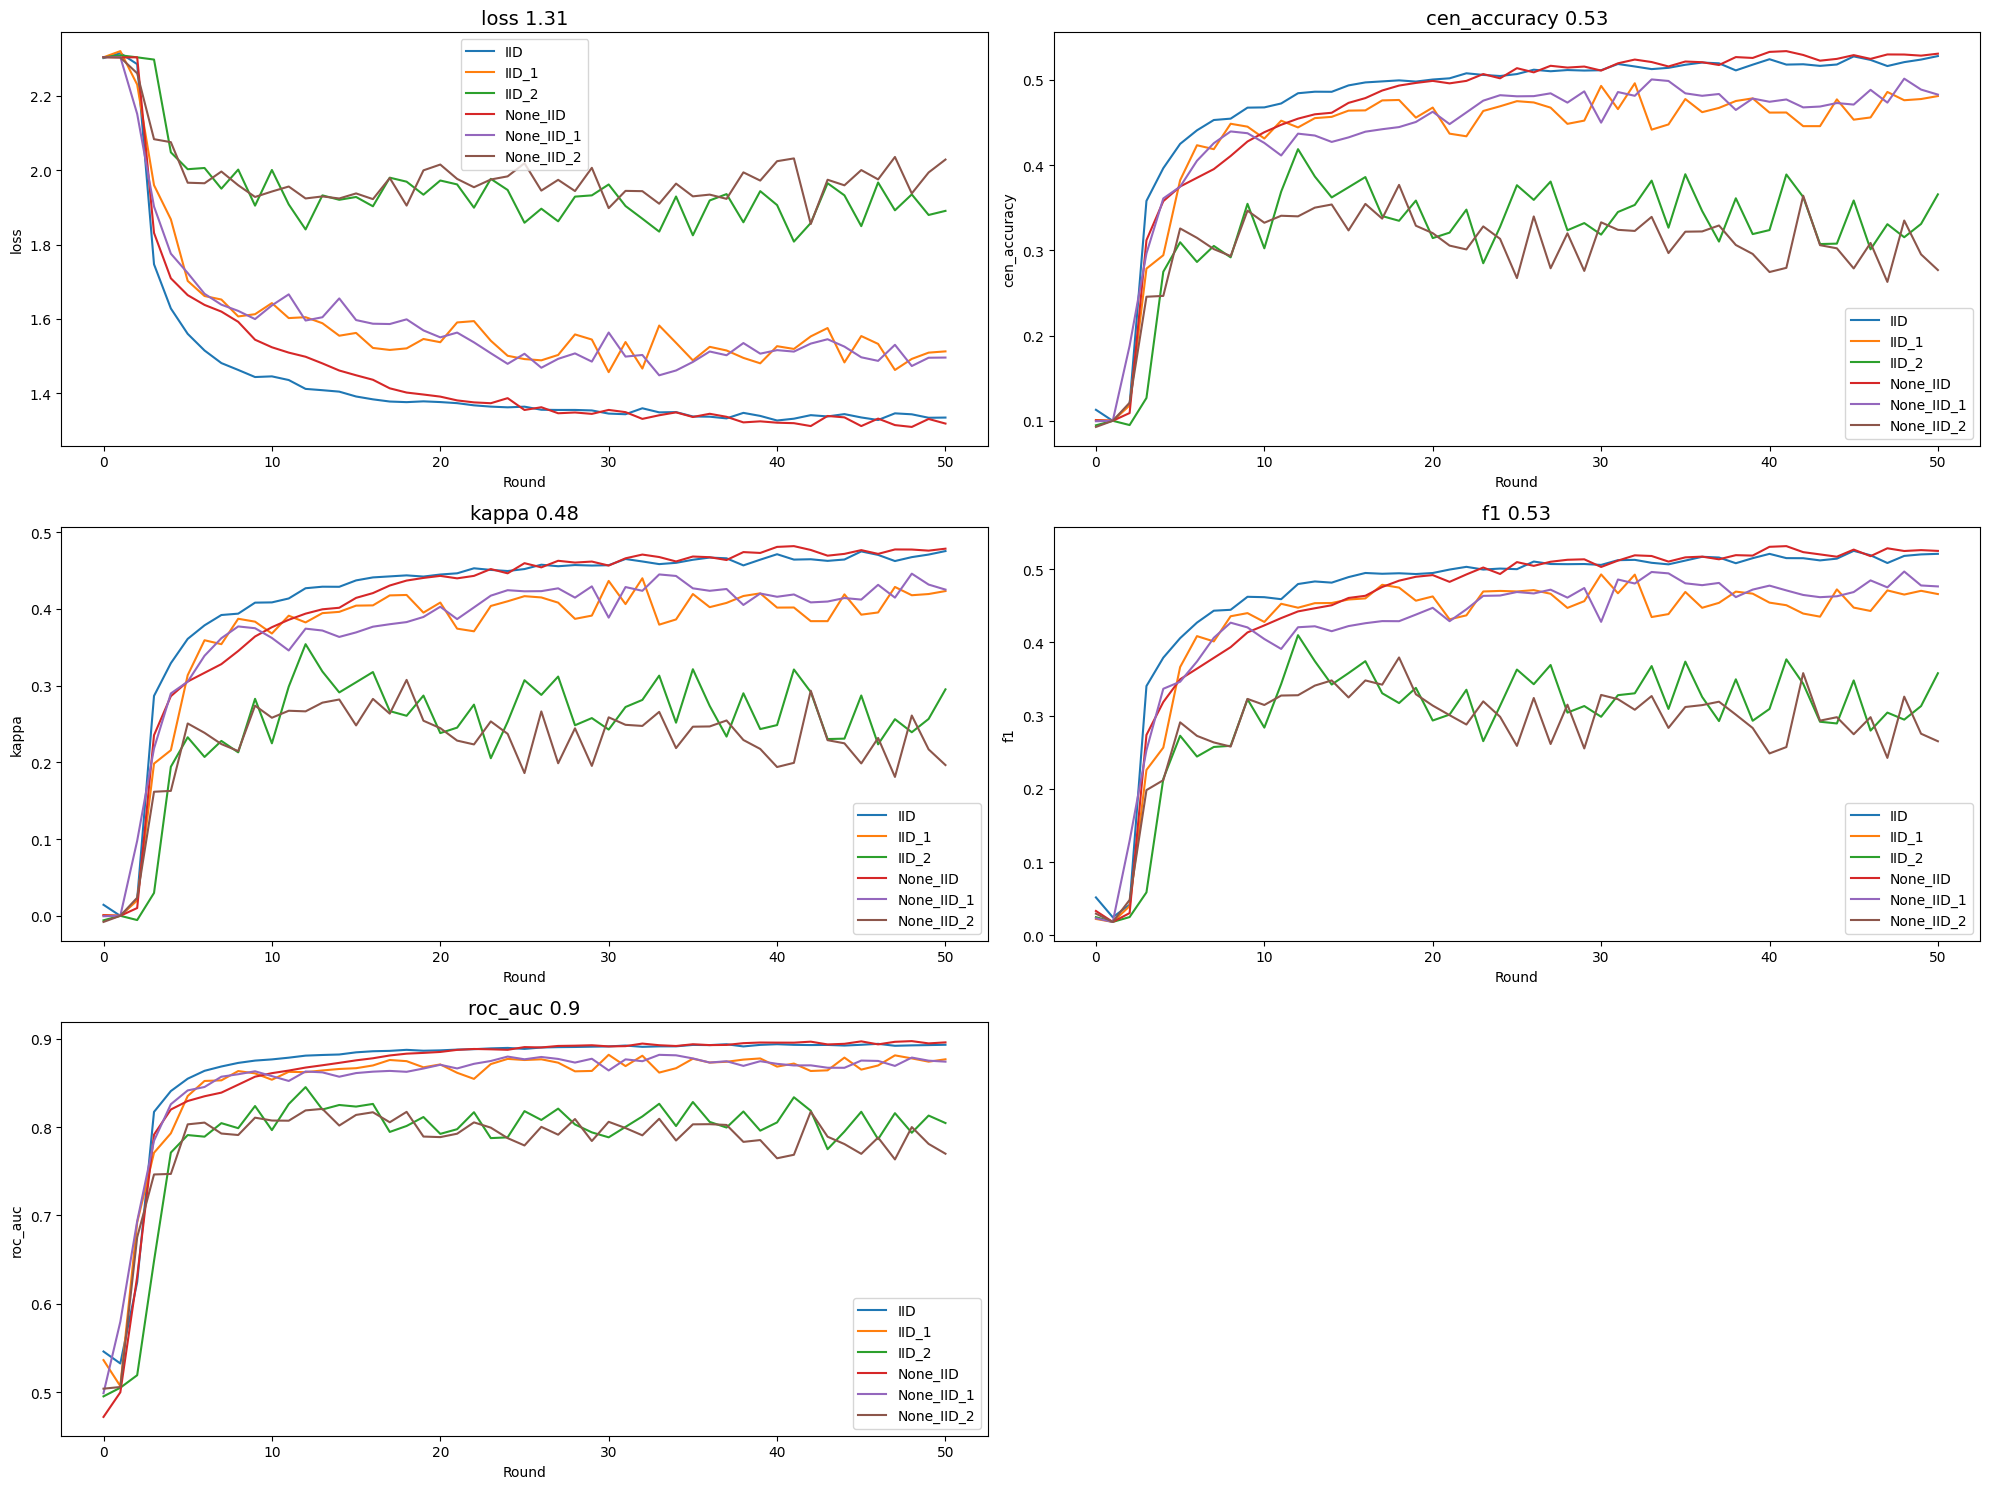

In [2]:
plot([
    "IID",
    "IID_1",
    "IID_2",
    "None_IID",
    "None_IID_1",
    "None_IID_2"
])

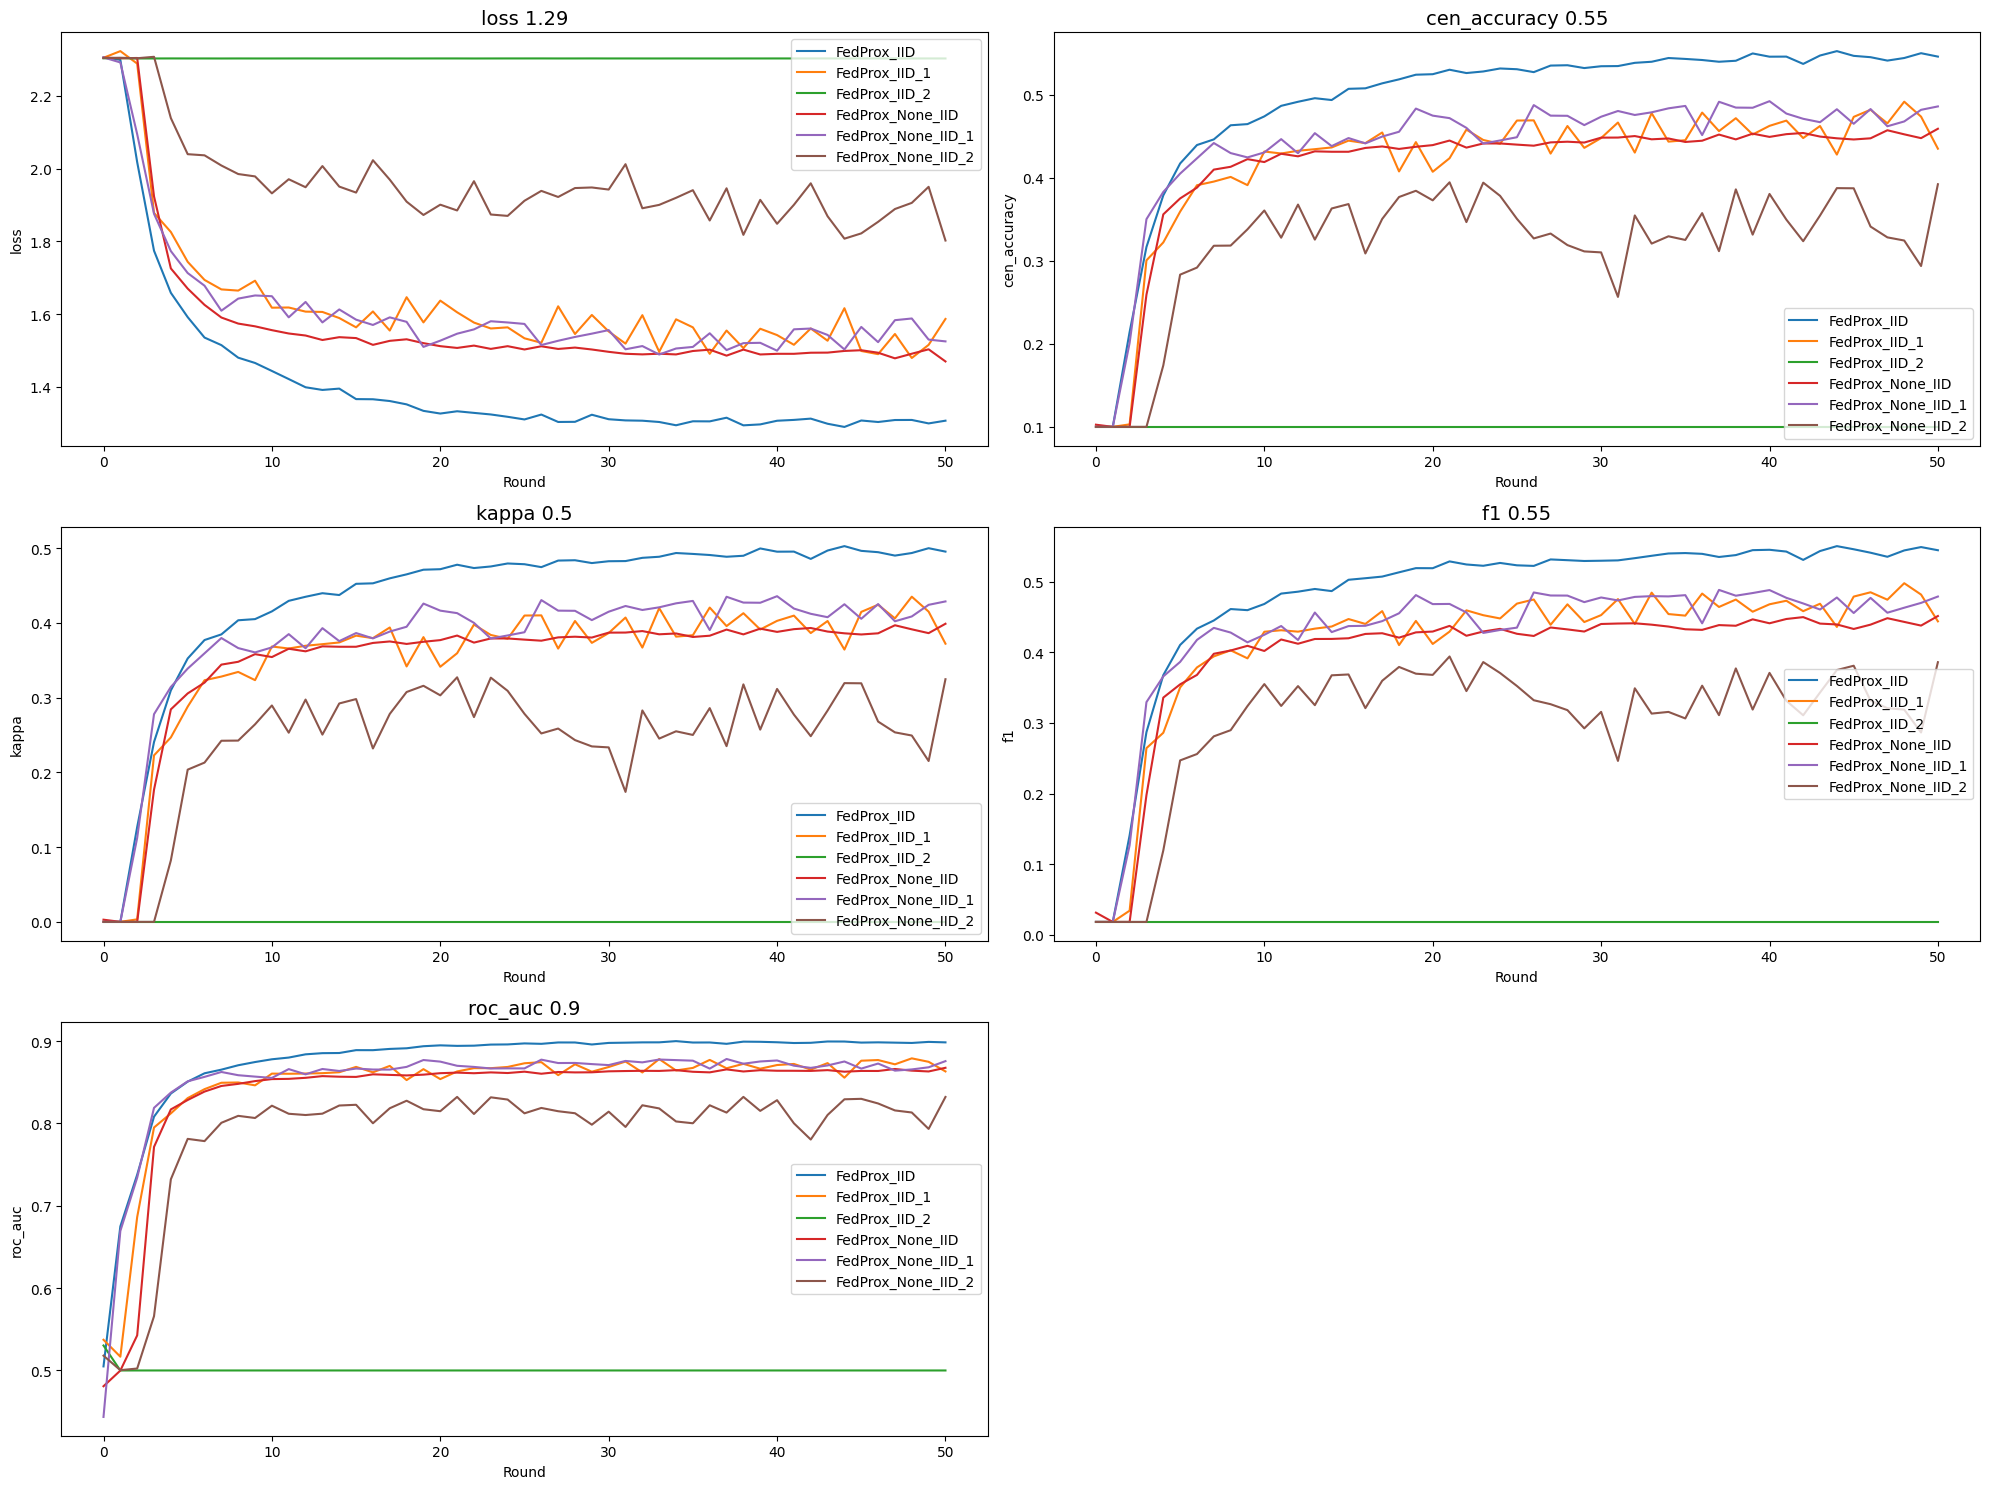

In [3]:
plot([
    "FedProx_IID",
    "FedProx_IID_1",
    "FedProx_IID_2",
    "FedProx_None_IID",
    "FedProx_None_IID_1",
    "FedProx_None_IID_2"
])

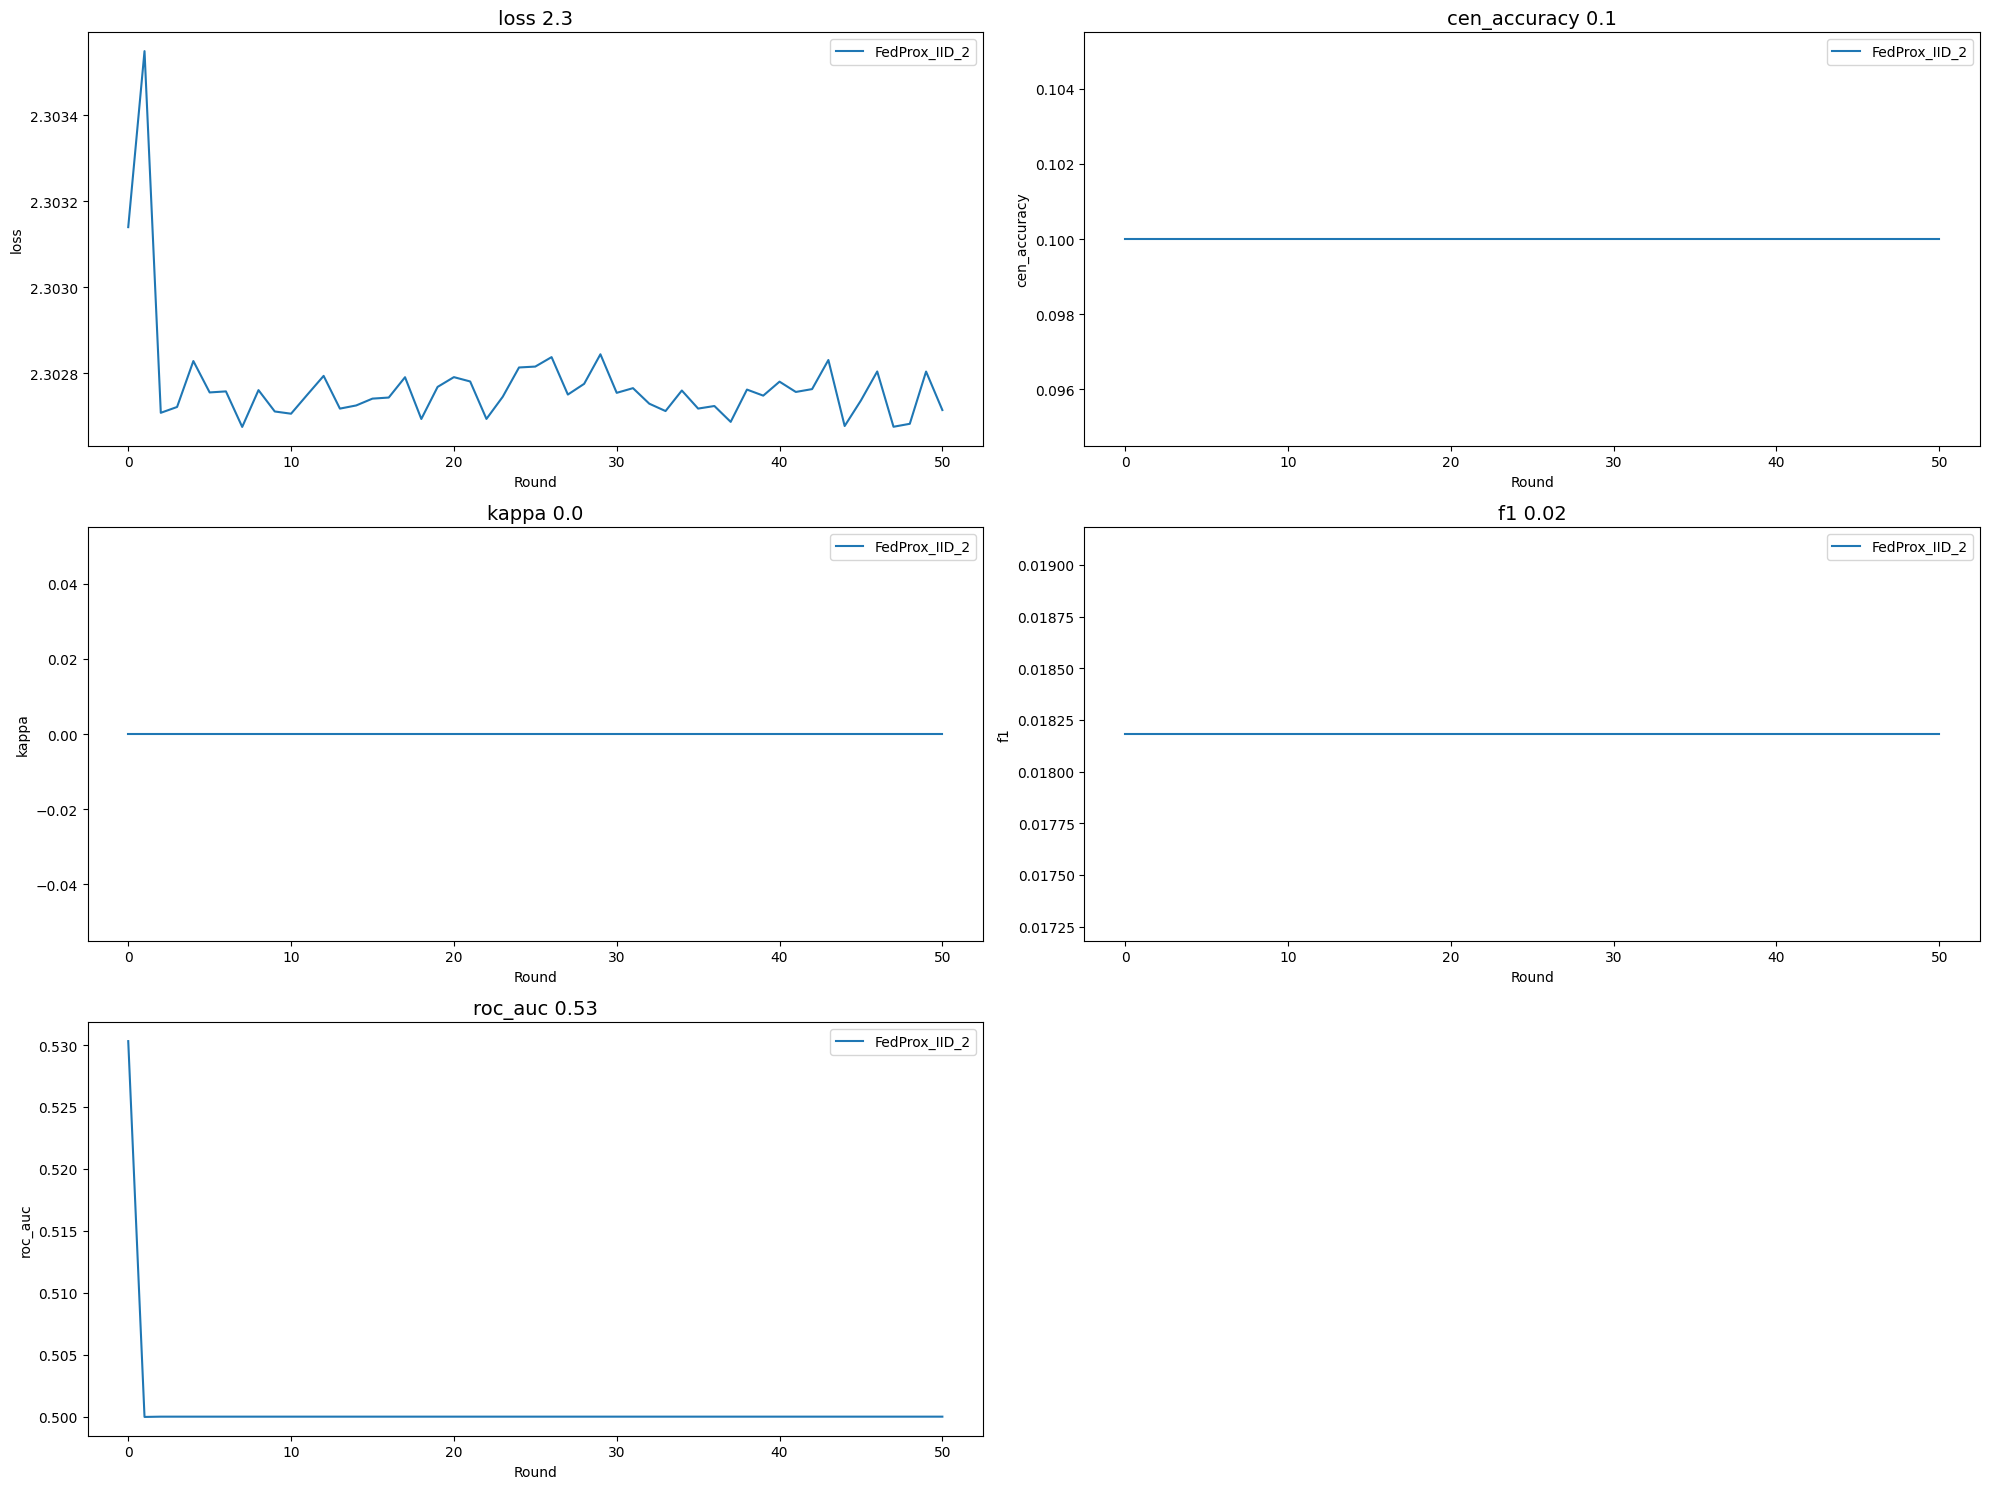

In [33]:
plot([
    "FedProx_IID_2"
])

### Mean and shared STD Area


In [8]:
import json
import numpy as np
import matplotlib.pyplot as plt

def plot(experiments):
    metric_names = ["loss", "cen_accuracy", "kappa", "f1", "roc_auc"]

    fig, axes = plt.subplots(3, 2, figsize=(20, 15))
    axes = axes.flatten()

    # Load JSON files
    all_data = {}
    for exp in experiments:
        with open(f"{exp}.json", "r") as f:
            metrics = json.load(f)
        rounds = sorted([int(k) for k in metrics.keys()])
        all_data[exp] = {
            "rounds": rounds,
            "metrics": metrics
        }

    # Plot each metric
    for i, metric_name in enumerate(metric_names):
        ax = axes[i]

        # Collect all experiment curves for mean/std
        all_curves = []

        # Plot all experiments individually
        for exp in experiments:
            rounds = all_data[exp]["rounds"]
            metrics = all_data[exp]["metrics"]

            values = np.array([metrics[str(r)][metric_name] for r in rounds])
            all_curves.append(values)

            ax.plot(rounds, values, alpha=0.5, label=f"{exp}")

        # Compute mean + std across experiments
        all_curves = np.array(all_curves)   # shape: (num_exp, num_rounds)
        means = all_curves.mean(axis=0)
        stds = all_curves.std(axis=0)

        # Plot mean curve
        ax.plot(rounds, means, color="black", linewidth=3, label="mean")

        # Shaded std area
        ax.fill_between(
            rounds,
            means - stds,
            means + stds,
            color="gray",
            alpha=0.2,
        )

        # Title stats
        if metric_name == "loss":
            ax.set_title(f"{metric_name} min={means.min():.3f}", fontsize=14)
        else:
            ax.set_title(f"{metric_name} max={means.max():.3f}", fontsize=14)

        ax.set_xlabel("Round")
        ax.set_ylabel(metric_name)
        ax.legend()

    axes[-1].axis("off")
    plt.tight_layout()
    plt.show()


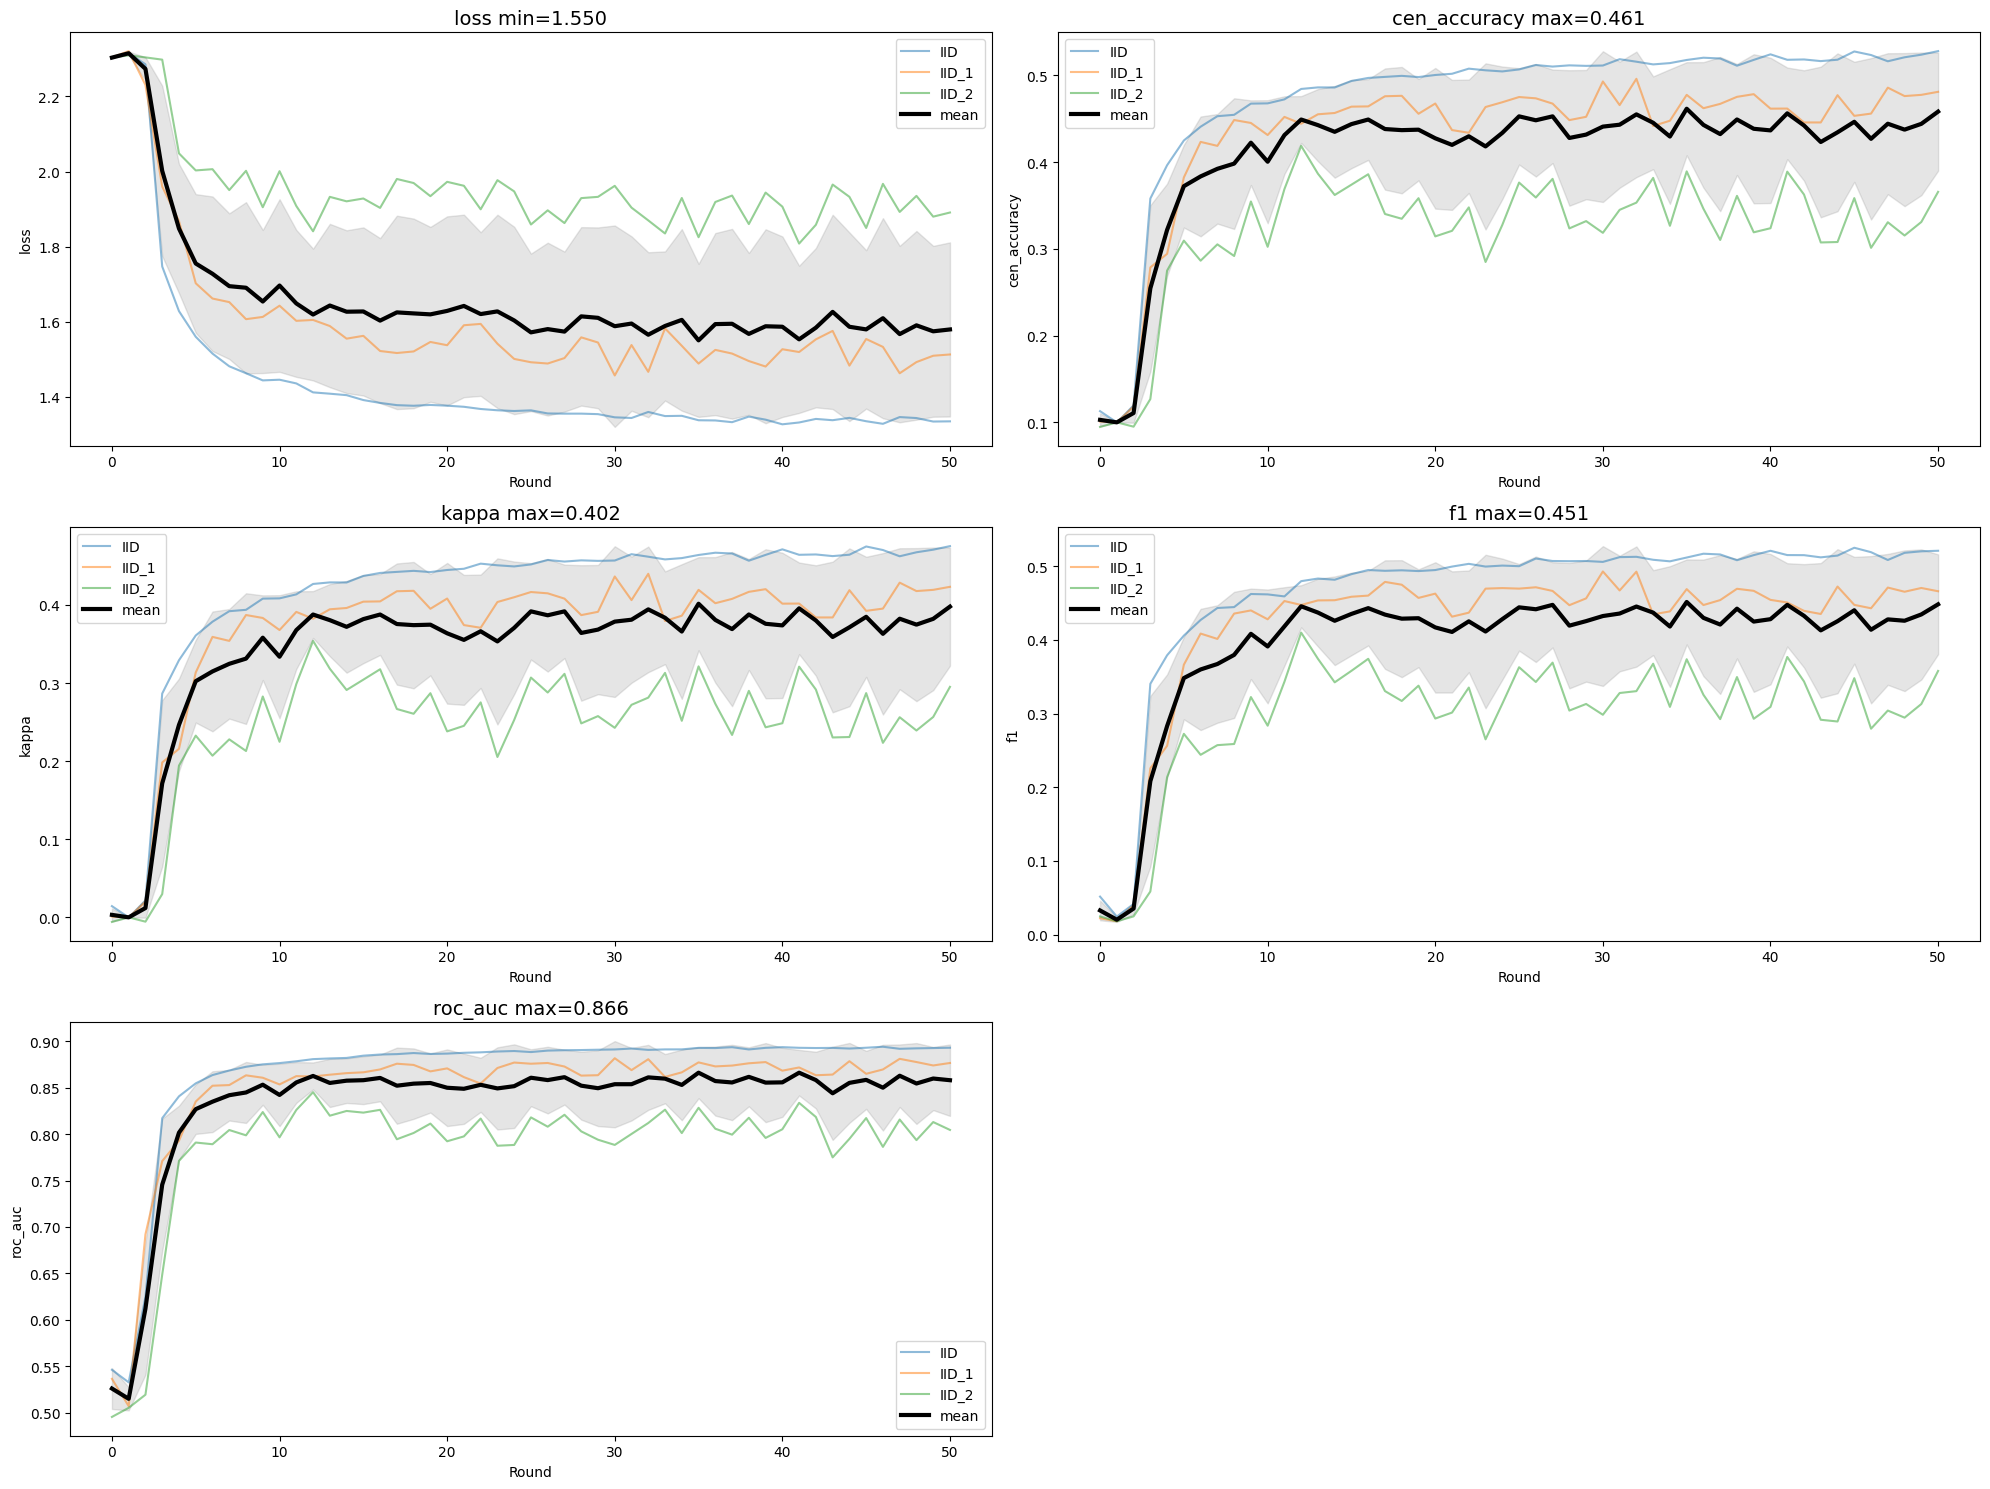

In [ ]:
plot(["IID", "IID_1", "IID_2"])


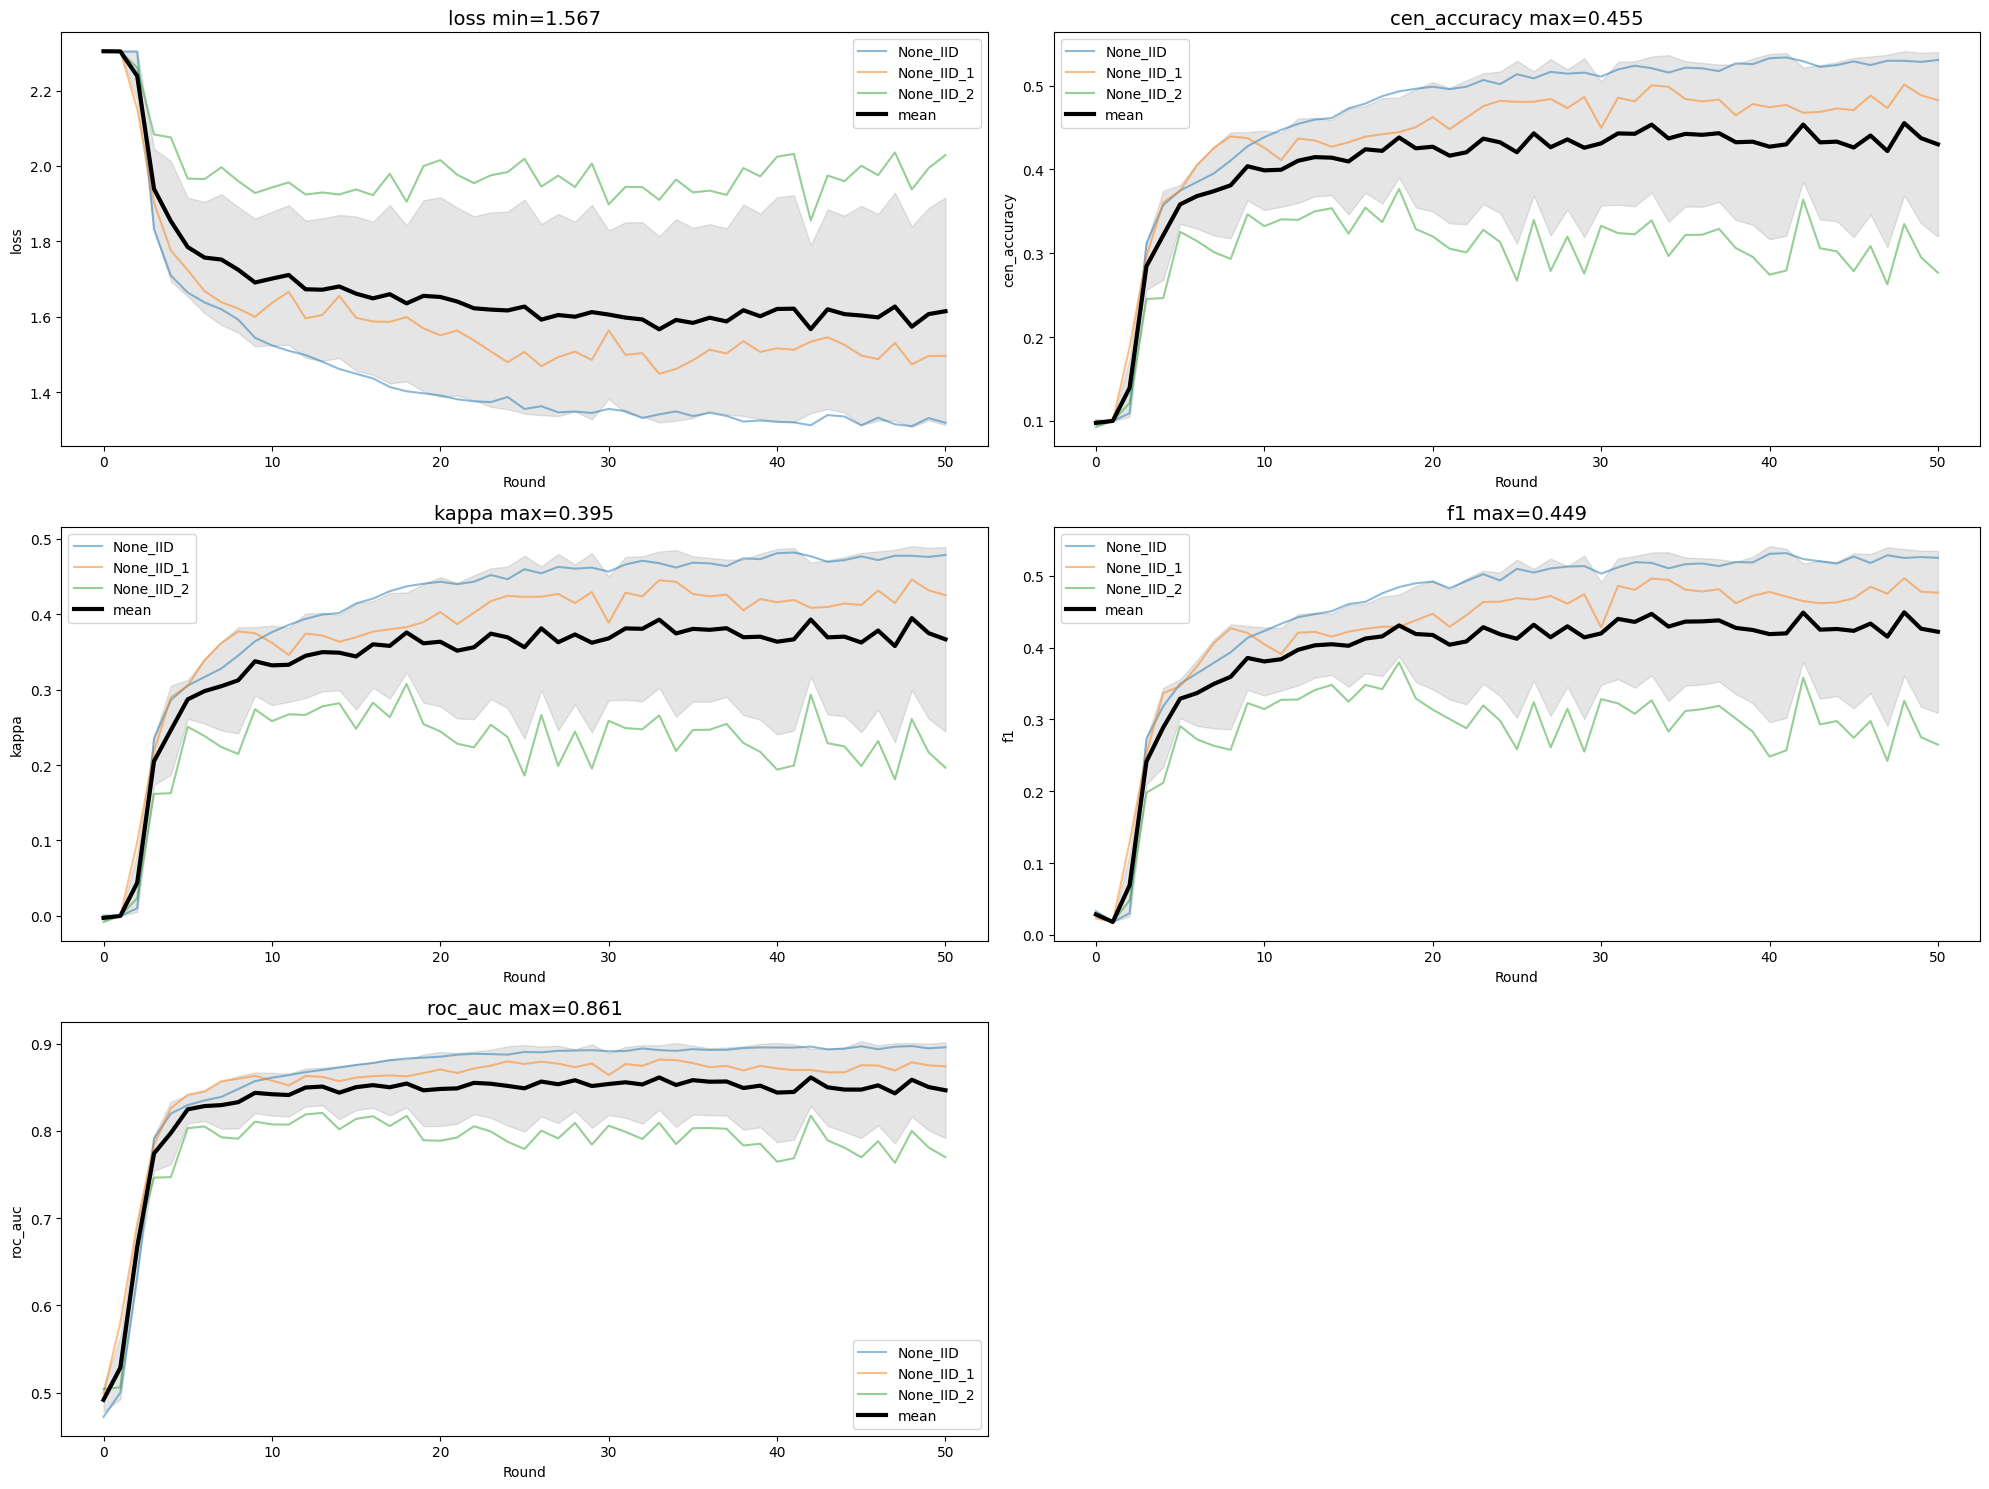

In [14]:
plot(["None_IID", "None_IID_1", "None_IID_2"])


In [16]:
import json
import numpy as np
import matplotlib.pyplot as plt

def plot_group_compare(iid_experiments, non_iid_experiments):
    metric_names = ["loss", "cen_accuracy", "kappa", "f1", "roc_auc"]

    fig, axes = plt.subplots(3, 2, figsize=(20, 15))
    axes = axes.flatten()

    def load_group(experiments):
        group_curves = {m: [] for m in metric_names}
        rounds_ref = None

        for exp in experiments:
            with open(f"{exp}.json", "r") as f:
                metrics = json.load(f)
            rounds = sorted([int(k) for k in metrics.keys()])

            if rounds_ref is None:
                rounds_ref = rounds
            else:
                # här antar vi samma rounds i alla experiment
                assert rounds == rounds_ref, f"Rounds mismatch in {exp}"

            for m in metric_names:
                values = [metrics[str(r)][m] for r in rounds]
                group_curves[m].append(values)

        # numpy-ify
        for m in metric_names:
            group_curves[m] = np.array(group_curves[m])  # shape: (num_exp, num_rounds)

        return rounds_ref, group_curves

    # ladda båda grupper
    iid_rounds, iid_curves = load_group(iid_experiments)
    non_rounds, non_curves = load_group(non_iid_experiments)

    assert iid_rounds == non_rounds, "IID och Non-IID har olika rounds"
    rounds = iid_rounds

    for i, metric_name in enumerate(metric_names):
        ax = axes[i]

        iid_vals = iid_curves[metric_name]
        non_vals = non_curves[metric_name]

        iid_mean = iid_vals.mean(axis=0)
        iid_std  = iid_vals.std(axis=0)

        non_mean = non_vals.mean(axis=0)
        non_std  = non_vals.std(axis=0)

        # IID
        ax.plot(rounds, iid_mean, label="IID", linewidth=2)
        ax.fill_between(rounds, iid_mean - iid_std, iid_mean + iid_std, alpha=0.2)

        # Non-IID
        ax.plot(rounds, non_mean, label="Non-IID", linewidth=2)
        ax.fill_between(rounds, non_mean - non_std, non_mean + non_std, alpha=0.2)

        if metric_name == "loss":
            best_val = min(iid_mean.min(), non_mean.min())
        else:
            best_val = max(iid_mean.max(), non_mean.max())

        ax.set_title(f"{metric_name} best={best_val:.3f}")
        ax.set_xlabel("Round")
        ax.set_ylabel(metric_name)
        ax.legend()

    axes[-1].axis("off")
    plt.tight_layout()
    plt.show()



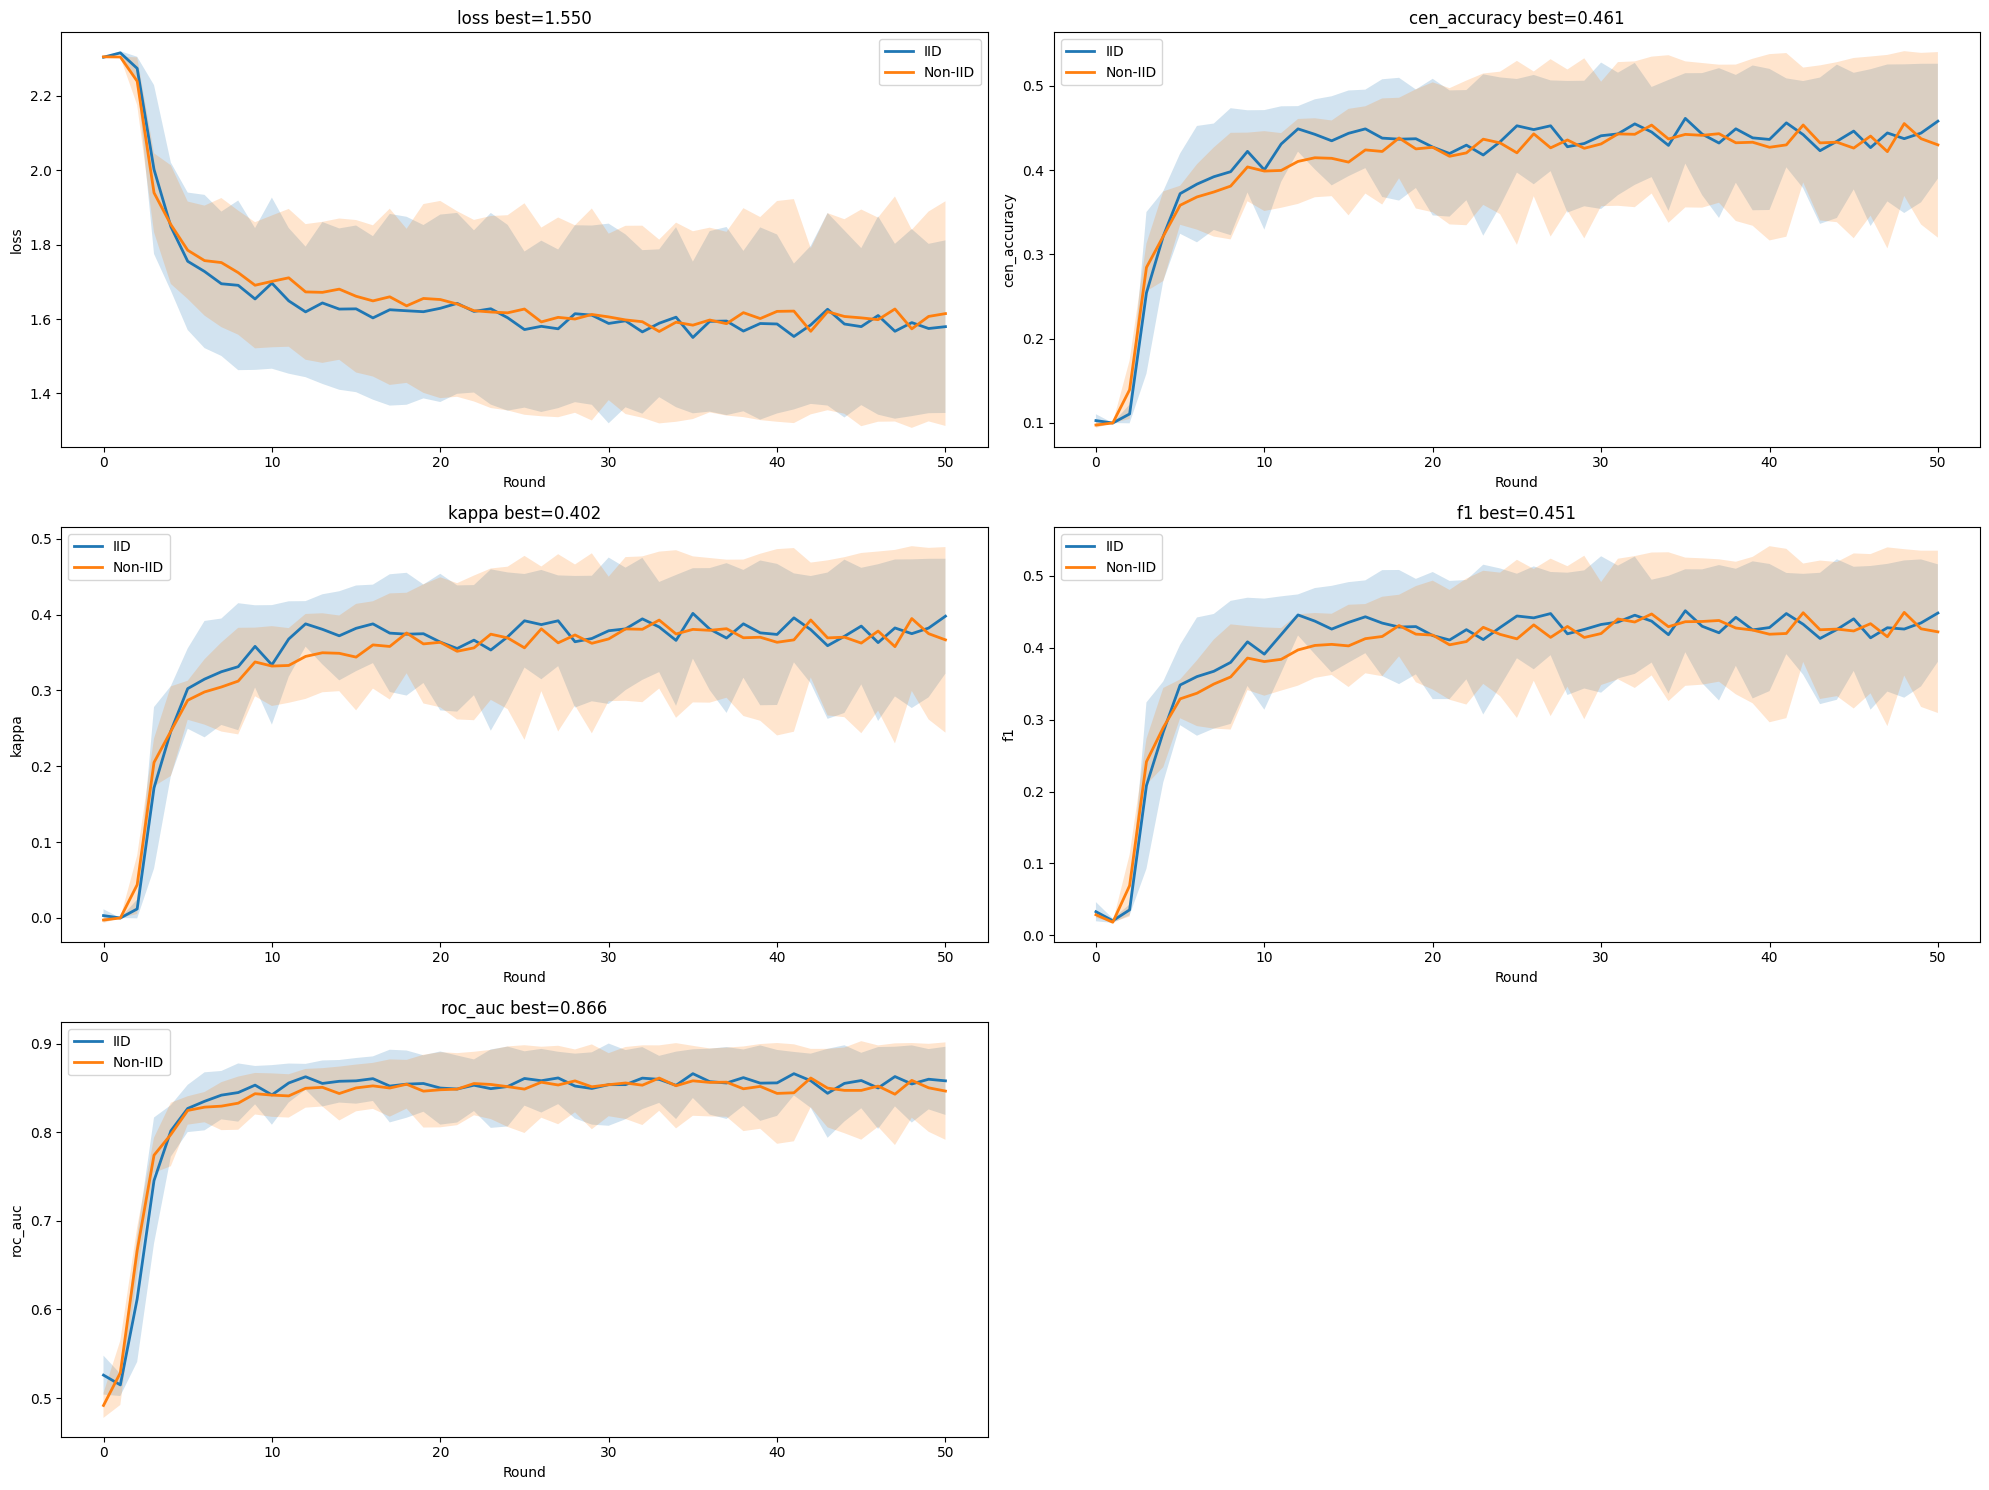

In [17]:
plot_group_compare(
    ["IID", "IID_1", "IID_2"],
    ["None_IID", "None_IID_1", "None_IID_2"],
)

### FEDPROX: Mean and shared STD Area

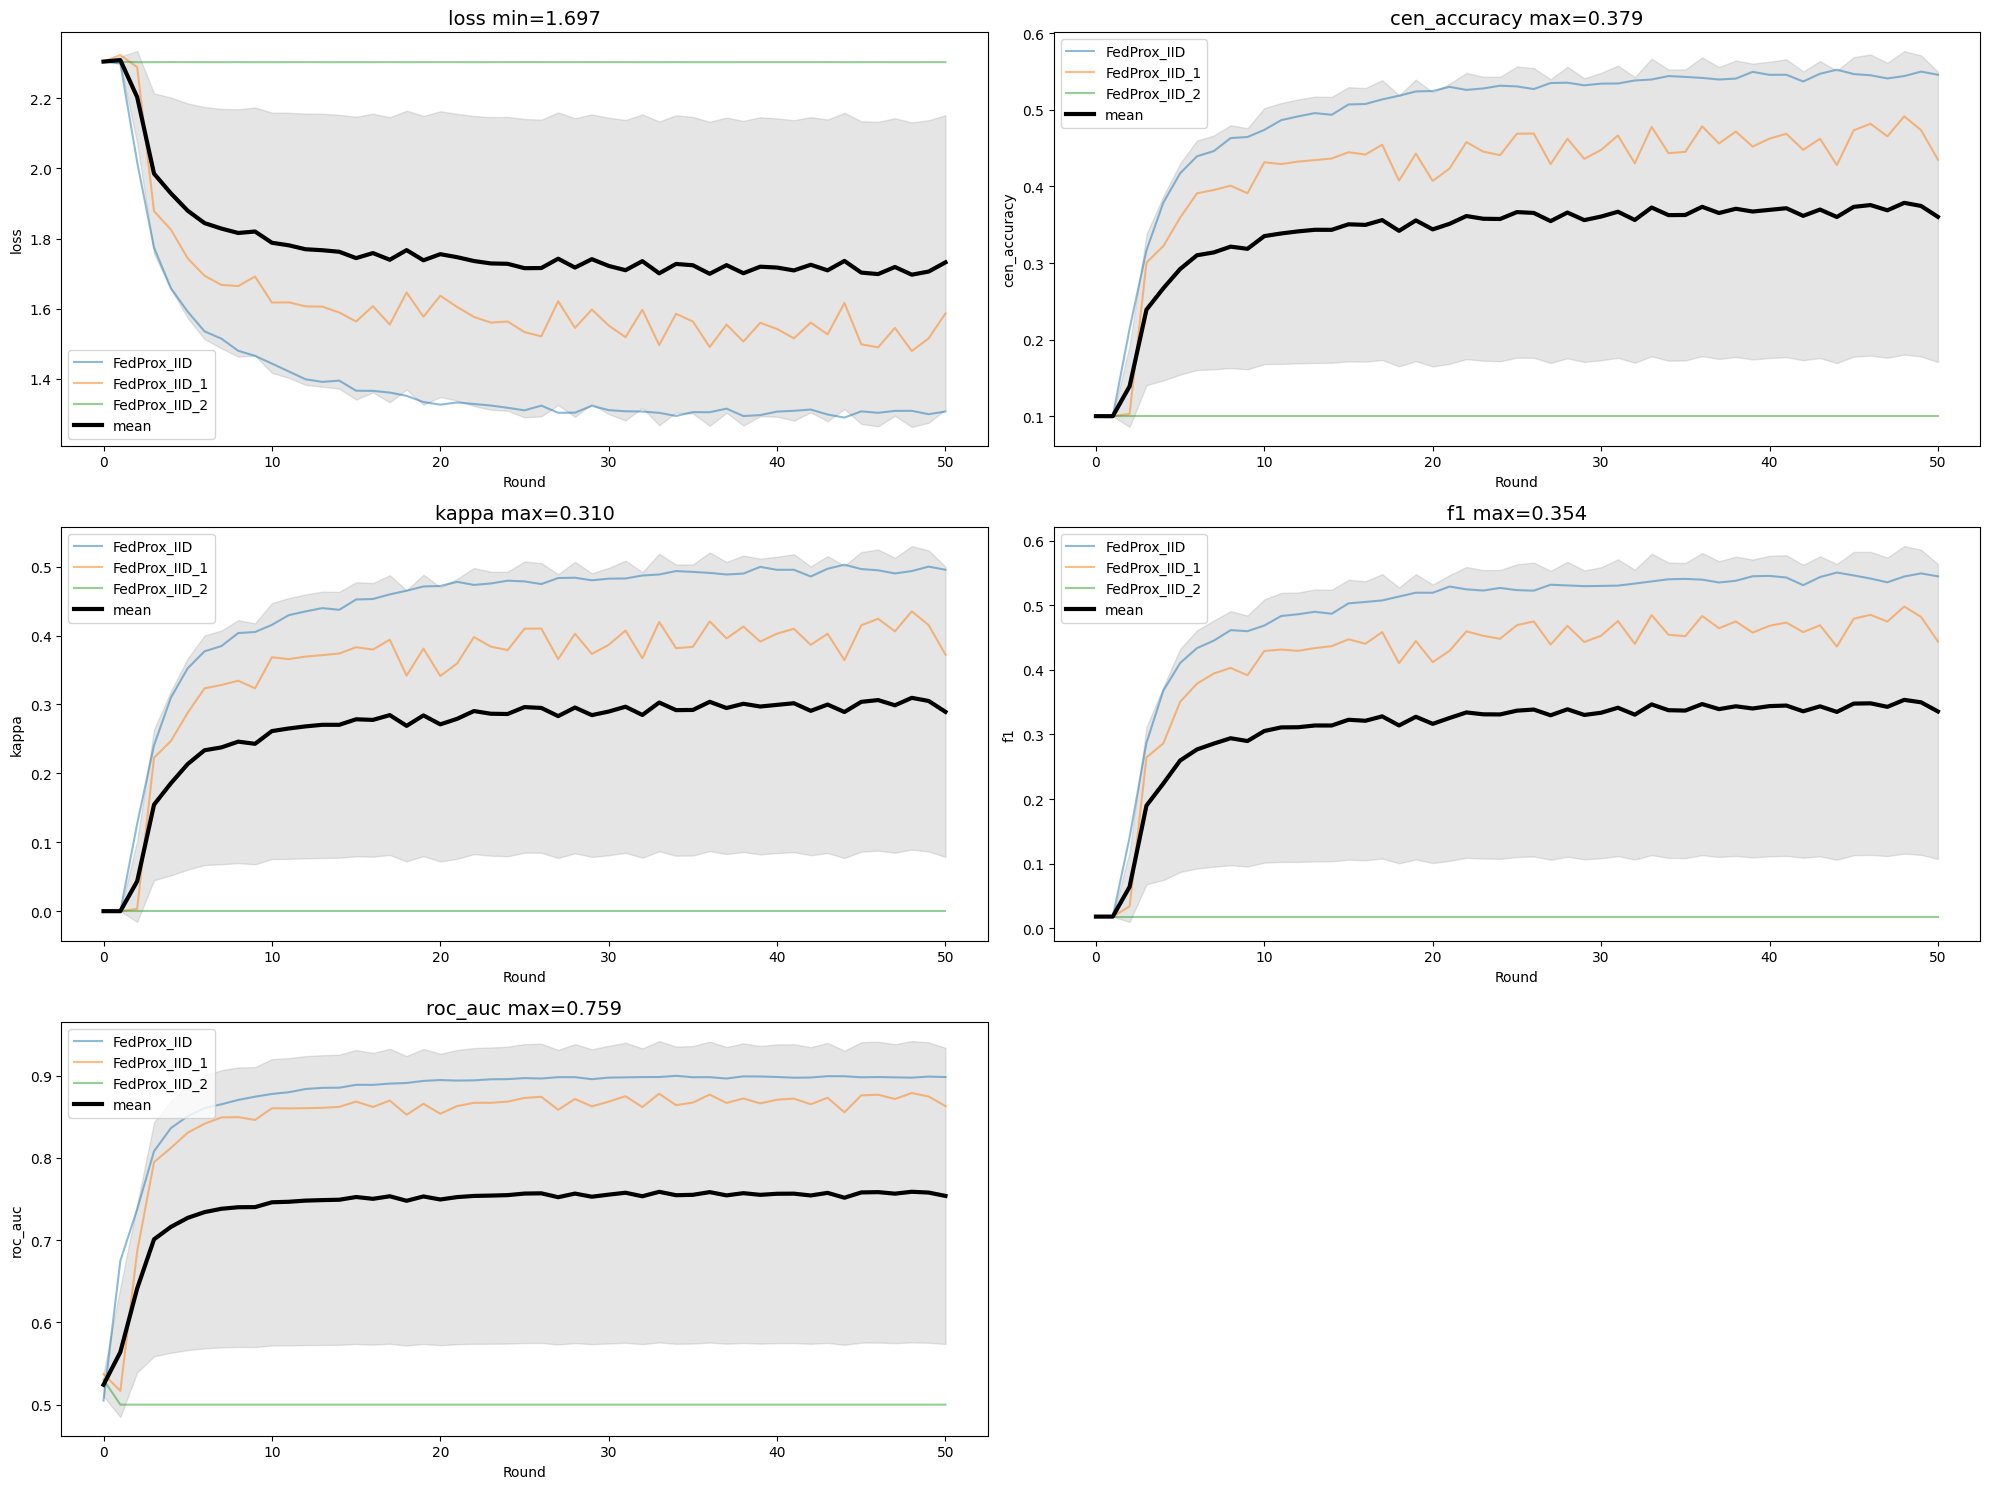

In [18]:
plot(["FedProx_IID", "FedProx_IID_1", "FedProx_IID_2"])

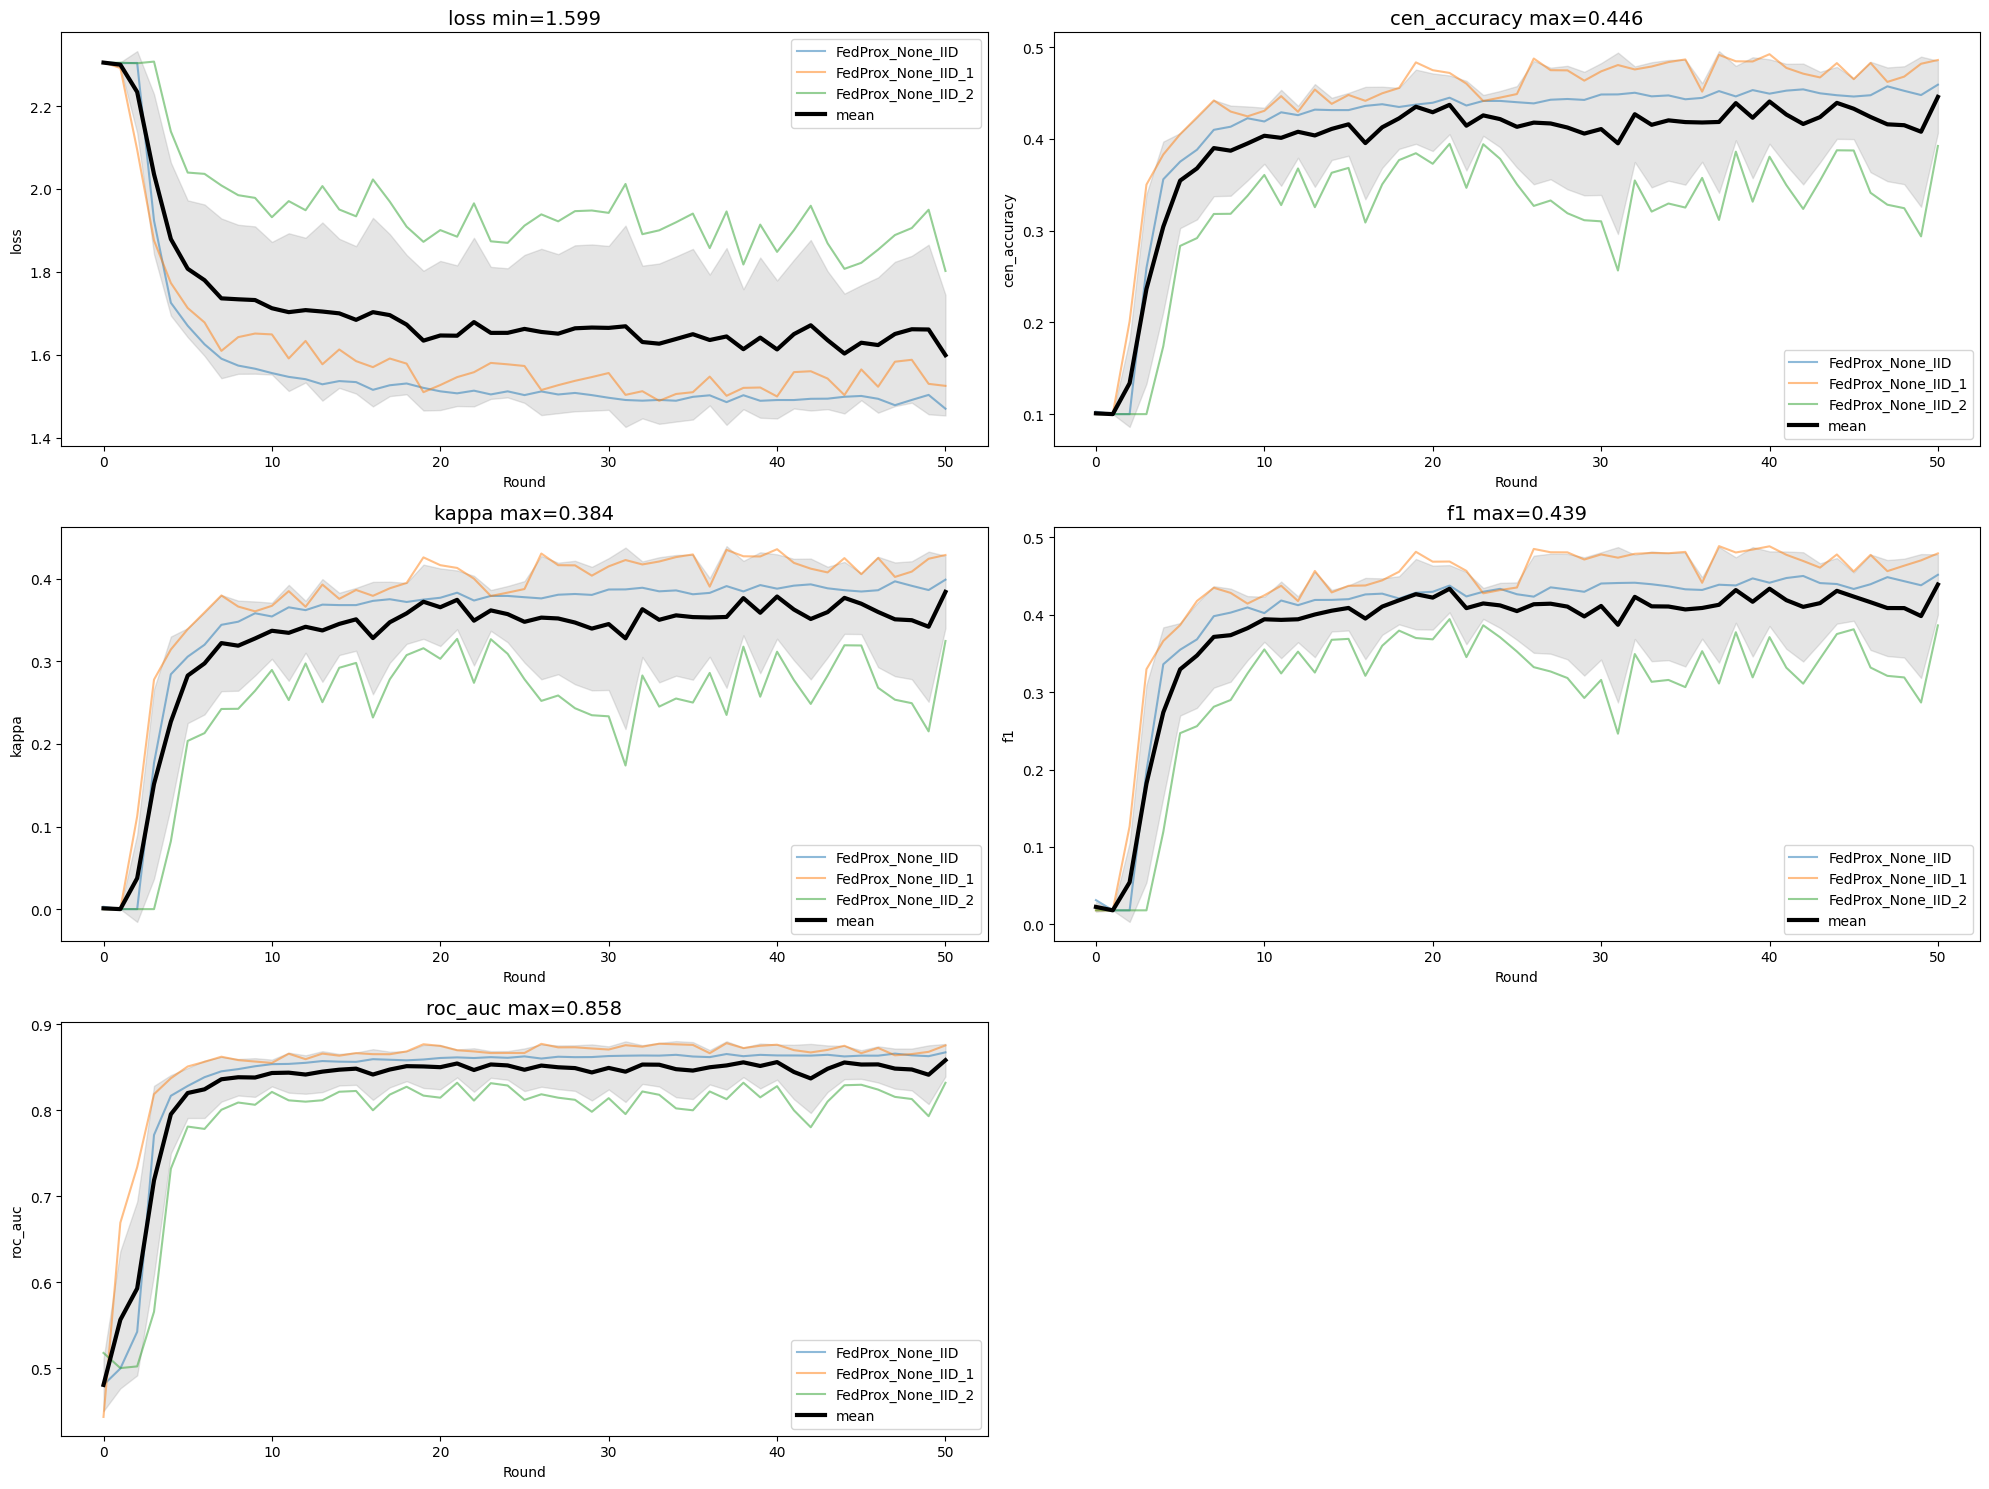

In [19]:
plot(["FedProx_None_IID", "FedProx_None_IID_1", "FedProx_None_IID_2"])

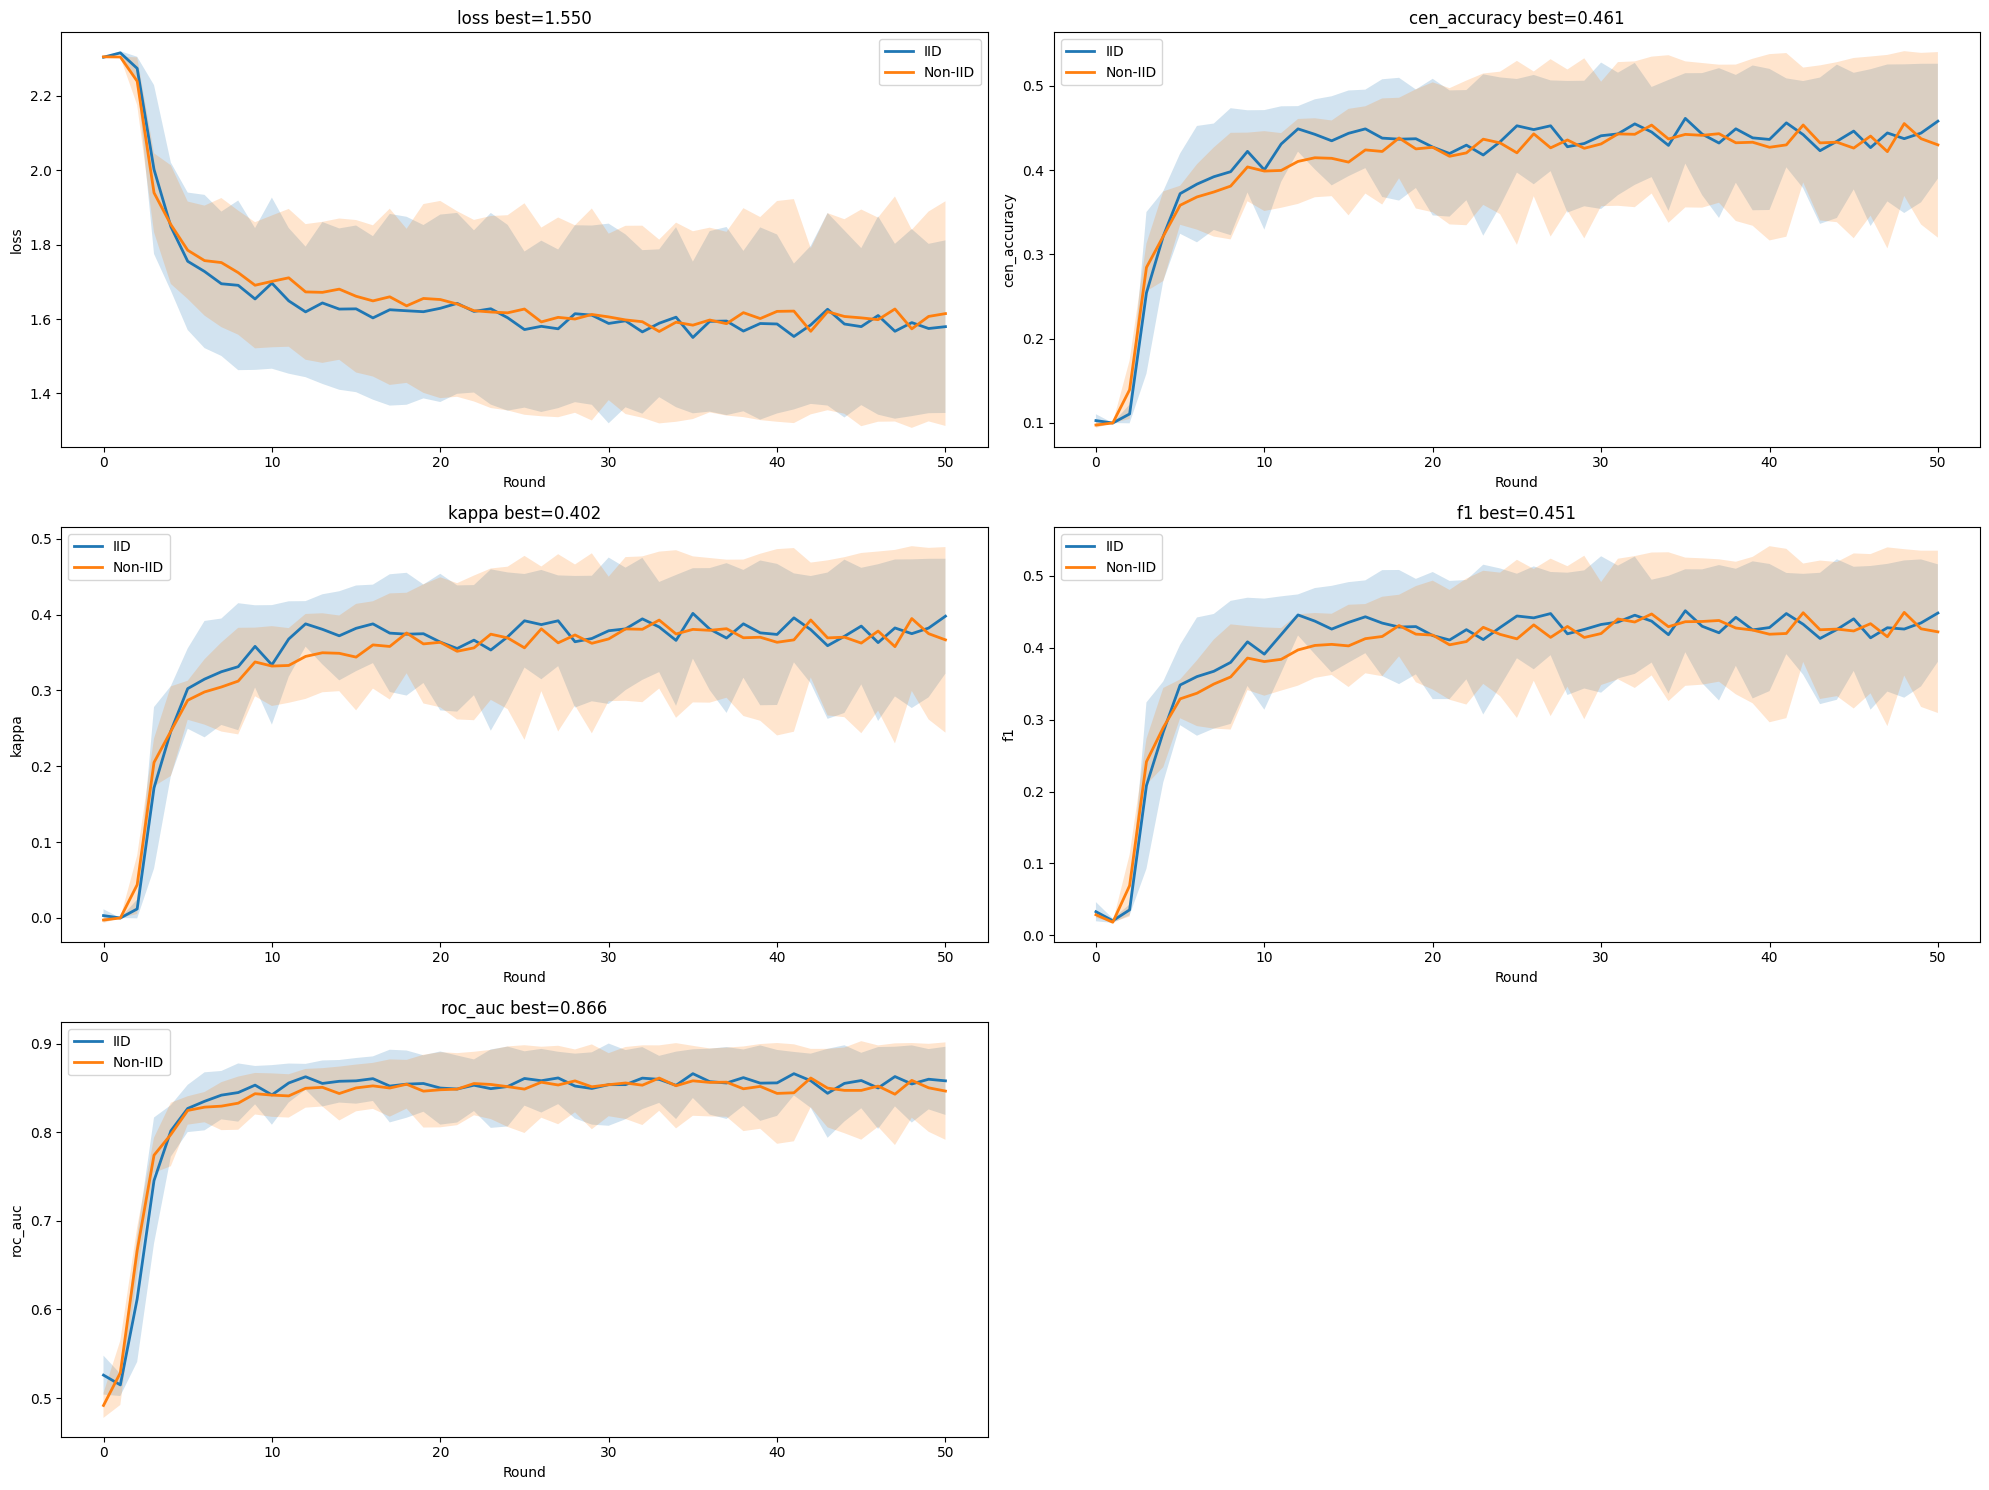

In [20]:
plot_group_compare(
    ["IID", "IID_1", "IID_2"],
    ["None_IID", "None_IID_1", "None_IID_2"],
)